In [1]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
load_dotenv()

True

In [3]:
model =ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
from pydantic import BaseModel, Field

In [5]:
from typing import Literal

In [6]:
class reviewState(TypedDict):
    review : str
    sentiment : Literal["positive","negative"]
    diagnosis: map
    negativeResponse : str
    positiveResponse: str

In [7]:
class sentimentSchema(BaseModel):
    sentiment : Literal["positive","negative"] = Field(description='Sentiment of the review')

In [8]:
llmWithSentimentSchema= model.with_structured_output(sentimentSchema)

In [9]:
class diagonisisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [10]:
llmDiagSchema=model.with_structured_output(diagonisisSchema)

In [11]:
def findSentiment(state : reviewState):
    prompt=f'For the following review find out the sentiment \n {state["review"]}'
    response=llmWithSentimentSchema.invoke(prompt).sentiment
    return { 'sentiment':response}

In [12]:
def runDiag(state : reviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    reponse= llmDiagSchema.invoke(prompt)
    return {
        'diagnosis':reponse.model_dump()
    }

In [13]:
def positiveResponse(state : reviewState):
    prompt=f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    response=model.invoke(prompt)
    return {
        'positiveResponse': response.content
    }

In [14]:
def negativeResponse(state : reviewState):
    diagnosis= state['diagnosis']
    prompt=f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response=model.invoke(prompt)
    return {
        'positiveResponse': response.content
    }

In [26]:
def condition(state : reviewState):
    if(state['sentiment']=='positive'):
        return "positiveResponse"
    else:
        return 'runDiag'

In [27]:
graph= StateGraph(reviewState)
graph.add_node('findSentiment',findSentiment)
graph.add_node('runDiag',runDiag)
graph.add_node('positiveResponse',positiveResponse)
graph.add_node('negativeResponse',negativeResponse)

graph.add_edge(START,'findSentiment')
graph.add_conditional_edges(
    'findSentiment',
    condition,
    # This dictionary tells the graph: "If the function returns X, go to Node Y"
    {
        "positiveResponse": "positiveResponse", 
        "runDiag": "runDiag"
    }
)
graph.add_edge('runDiag','negativeResponse')
graph.add_edge('negativeResponse',END)
graph.add_edge('positiveResponse',END)

workflow=graph.compile()

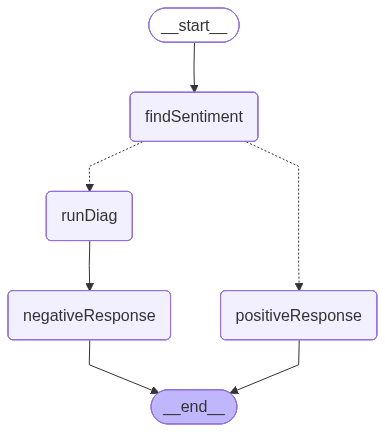

In [28]:
workflow

In [29]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
final_state=workflow.invoke(intial_state)

In [30]:
final_state

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'positiveResponse': 'Subject: Good News! Your Reported Bug with [Specific Feature/Area, if known] Has Been Resolved!\n\nHi [User Name],\n\nThank you for reaching out to us and for your patience while we investigated. I completely understand how frustrating it is when you encounter a bug, especially one that\'s high-urgency and disrupts your workflow. I\'m truly sorry for the inconvenience and stress this has caused you.\n\nI\'m happy to report that our team has successfully identified the root cause of the bug you experienced with [mention specific feature if known, e.g., "the report generation module" or "the checkout process"]. We\'ve deplo